In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
j=3
k=1
ecross = 1 - ((j-k)/j)**(2/3)    
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=1e-5, P=1, e=0., l=0)
sim.add(e=ecross, P=j/(j-k), l=np.pi)
sim.move_to_com()
sim.integrator="whfast"
sim.dt = 0.03
ps = sim.particles

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9360f8b150>)

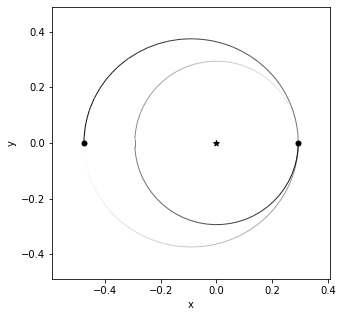

In [277]:
rebound.OrbitPlot(sim)

In [8]:
%matplotlib notebook

class Clicker(object):
    def __init__(self,j,k,m,etilde):
        fig, self.ax = plt.subplots(figsize=(12,8))
        self.j = j
        self.k = k
        self.m = m
        
        ecross = 1 - ((j-k)/j)**(2/3)
        self.e = etilde*ecross
        self.cid = self.ax.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        phi = event.xdata
        P = event.ydata
        
        # phi = j*l2 - (j-k)*l1 - k*pomega1
        # if pomega1 = 0, l1=0, l2 = phi/j
        sim = rebound.Simulation()
        sim.add(m=1)
        sim.add(m=self.m, P=1)
        sim.add(e=self.e, P=P, l=phi/self.j)
        sim.move_to_com()
        sim.integrator="whfast"
        sim.dt = 0.03
        ps = sim.particles

        Nout = 1000
        P, phi = np.zeros(Nout), np.zeros(Nout)
        times = np.linspace(0, 300, Nout)
        
        for i, time in enumerate(times):
            sim.integrate(time)
            P[i] = ps[2].P/ps[1].P
            phi[i] = np.mod(self.j*ps[2].l-(self.j-self.k)*ps[1].l-self.k*ps[2].pomega, 2*np.pi)
        
        self.ax.plot(phi, P, 'k.')

<IPython.core.display.Javascript object>


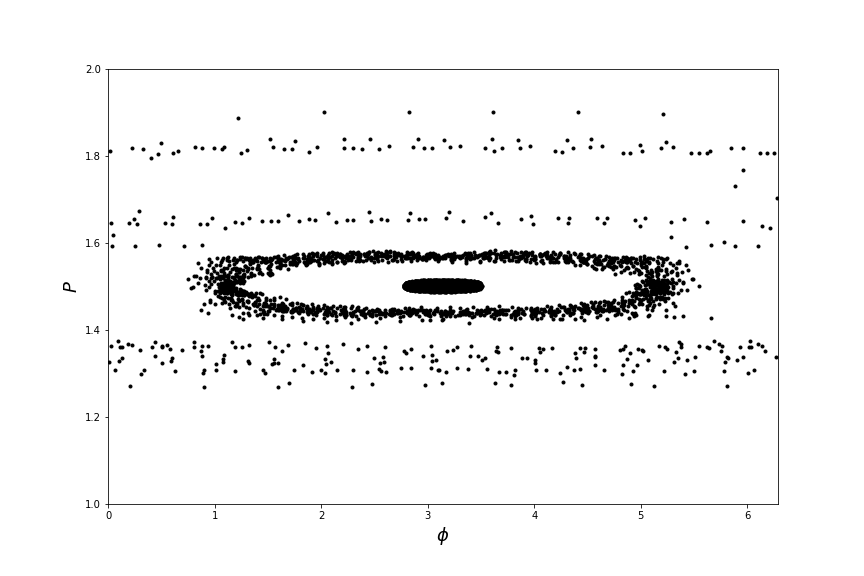

Text(0, 0.5, '$P$')

In [9]:
clicker=Clicker(j=3, k=1, m=1e-3, etilde=0.8) 

clicker.ax.set_xlim(0,2*np.pi)
clicker.ax.set_ylim(1, 2)
clicker.ax.set_xlabel('$\phi$',fontsize=18)
clicker.ax.set_ylabel('$P$',fontsize=18)

In [2]:
%matplotlib notebook

class Clicker(object):
    def __init__(self,j,k,m,etilde, Npts=300):
        fig, self.ax = plt.subplots(figsize=(12,8))
        self.j = j
        self.k = k
        self.m = m
        self.Npts = Npts
        
        ecross = 1 - ((j-k)/j)**(2/3)
        self.e = etilde*ecross
        self.cid = self.ax.figure.canvas.mpl_connect('button_press_event', self)
        
        if k > 5:
            raise("Only supports resonances of order k=5 or less")
        h = [0, 0.535, 0.426, 0.420, 0.454, 0.519] # coefficients for k order resonances
        self.ax.set_xlim([0,2*np.pi])
        #fracPwidth = 2*np.sqrt(3*h[k])*m**(1/2)*etilde**(k/2)
        #self.ax.set_ylim([j/(j-k)-10*Pwidth, j/(j-k)+10*Pwidth])
        self.ax.set_xlabel('$\phi$',fontsize=18)
        self.ax.set_ylabel('$P$',fontsize=18)
        
    def __call__(self, event):
        phi = event.xdata
        P = event.ydata
        
        sim = self.make_sim(phi, P, self.m, self.e, self.j)
        philist, Plist, collision = self.run(sim, self.j, self.k)
        if collision == True:
            if phi:
                self.ax.plot(philist, Plist, 'r.')
            else:
                self.ax.plot([phi], [P], 'r.') # plot initial point in case collision happens before first crossing
        else:
            self.ax.plot(philist, Plist, 'k.')
    
    def make_sim(self, phi, P, m, e, j):
        # phi = j*l2 - (j-k)*l1 - k*pomega1
        # if pomega1 = 0, l1=0, l2 = phi/j
        sim = rebound.Simulation()
        sim.add(m=1)
        sim.add(m=m, P=1)
        sim.add(e=e, P=P, l=phi/j)
        sim.move_to_com()
        sim.particles[1].r = sim.particles[1].a*(sim.particles[1].m/3/sim.particles[0].m)**(1/3)
        sim.collision = "line"
        return sim

    def hyper(self, sim): # section when l1 overtakes l2. When l1 < l2, sin(l2-l1) > 0, when it overtakes, sin(l2-l1)<0
        return np.sin(sim.particles[2].l-sim.particles[1].l) 

    def run(self, sim, j, k):
        N_points_max = self.Npts # maximum number of point in our Poincare Section
        N_points = 0
        poincare_map = np.zeros((N_points_max,2))
        ps = sim.particles
        
        # Integrate simulation in small intervals
        # After each interval check if we crossed the 
        # hypersurface. If so, bisect until we hit the 
        # hypersurface exactly up to a precision
        # of dt_epsilon
        dt = 0.1
        dt_epsilon = 1e-2*dt
        sign = self.hyper(sim)
        phi, P = [], []
        collision=False
        while sim.t<1e4 and N_points < N_points_max:
            oldt = sim.t
            olddt = sim.dt
            try:
                sim.integrate(oldt+dt)
            except rebound.Collision:
                collision=True
                return phi, P, collision
            nsign = self.hyper(sim)
            if sign > 0 and nsign < 0.: # see condition in hyper
                # Hyper surface crossed.
                leftt = oldt
                rightt = sim.t
                sim.dt = -olddt
                while (rightt-leftt > dt_epsilon):
                    # Bisection.
                    midt = (leftt+rightt)/2.
                    try:
                        sim.integrate(midt)
                    except:
                        collision=True
                        return phi, P, collision
                    
                    msign = self.hyper(sim)
                    if msign*sign > 0.:
                        leftt = midt
                        sim.dt = 0.3*olddt
                    else:
                        rightt = midt
                        sim.dt = -0.3*olddt
                # Hyper surface found up to precision of dt_epsilon. Store phi and P
                # Don't need to check crossing direction, since l1 always overtakes l2. But need to check (l2-l1) != pi
                if np.cos(ps[2].l-ps[1].l) > 0: 
                    tp = np.pi*2.
                    phi.append(np.mod(j*ps[2].l-(j-k)*ps[1].l-k*ps[2].pomega, 2*np.pi))
                    P.append(ps[2].P/ps[1].P) # Store value for map
                    N_points += 1
                sim.dt = olddt
                try:
                    sim.integrate(oldt+dt)
                except:
                    collision=True
                    return phi, P, collision
            sign = nsign
        return phi, P, collision

<IPython.core.display.Javascript object>


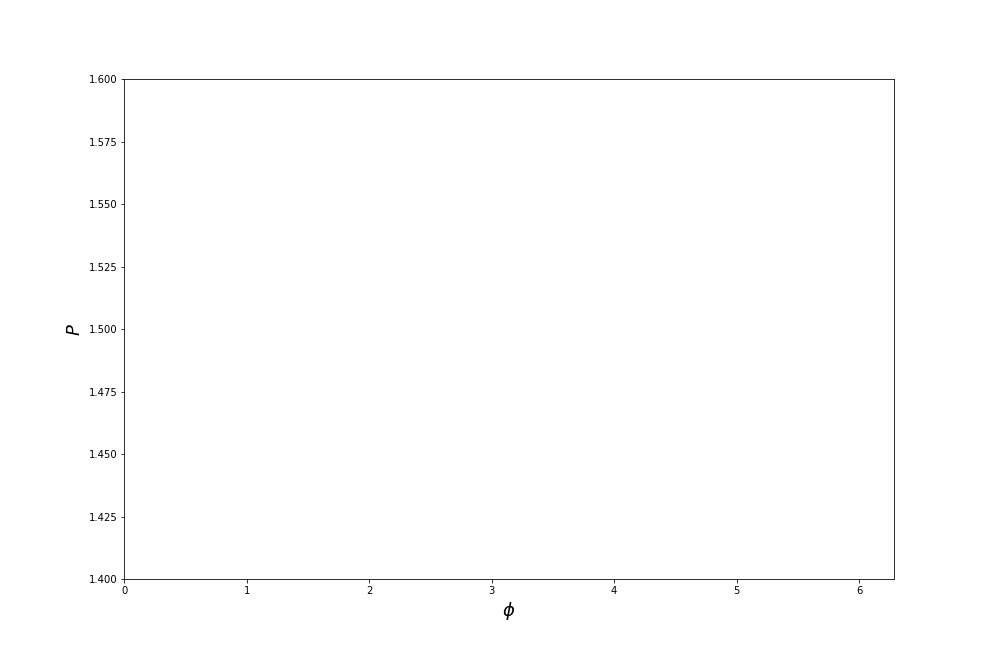

(0.0, 6.283185307179586)

In [3]:
%matplotlib notebook

clicker=Clicker(j=3, k=1, m=1e-5, etilde=0.3) 
clicker.ax.set_ylim([1.4, 1.6])
clicker.ax.set_xlim([0, 2*np.pi])